# Model Zoo (Dense)

In [1]:
%env CUDA_VISIBLE_DEVICES=1

import numpy as np
import torch

from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

from torch.utils.data import Subset

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import torchvision.models as models
from torchvision.models import vgg19, resnet50, resnet18, resnet34, resnet101 
import timm # state-of-the-art (ViTs...)

from src.model_serving.model_server import *
import matplotlib.pyplot as plt

from datetime import datetime
import time

env: CUDA_VISIBLE_DEVICES=1


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
print(f"available_gpus: {len(available_gpus)}") 

Using cuda device
available_gpus: 1


In [3]:
from src.model_serving.model_server import *
import matplotlib.pyplot as plt

def profile_pt_model_(model_zoo, model_id: str, test_data: Dataset, latency_sample=1000):
    """
    Profile a pytorch model using all data in test_data and measure latency by 
    performing at most `latency_sample` number of queries.
    """
    print(f"Start profiling {model_id} ...")

    size = len(test_data)
    correct = 0
    with torch.no_grad():
        for X, y in DataLoader(test_data, batch_size=256):
            X, y = X.to(device), y.to(device)
            pred = model_zoo[model_id](X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    latencies = []
    for X, y in DataLoader(test_data, batch_size=1):
        X, y = X.to(device), y.to(device)
        start = time.perf_counter()
        pred = model_zoo[model_id](X)
        latencies.append((time.perf_counter() - start) * 1000) # convert to ms
        if len(latencies) >= latency_sample:
            break

    plt.cla()
    plt.hist(latencies, 20)
    plt.title(f"Latencies PDF for {model_id}")
    plt.xlabel("Latency (ms)")
    plt.savefig(f"figures/Latencies_PDF_for_{model_id}.png")

    plt.cla()
    plt.hist(latencies, histtype='step', cumulative=True)
    plt.title(f"Latencies CDF for {model_id}")
    plt.xlabel("Latency (ms)")
    plt.savefig(f"figures/Latencies_CDF_for_{model_id}.png")

    accuracy = correct / size
    latency = np.mean(latencies)
    return accuracy, latency


In [4]:
# !pip install huggingface_hub -U

In [5]:
model_zoo = {}

def load_model(model_name):
    if model_name in ['resnet18', 'resnet50', 'resnet101', 'vgg16', 'vgg19', 'densenet121',
                      'densenet201', 'mobilenet_v2', 'inception_v3', 'efficientnet_b0',
                      'efficientnet_b7', 'squeezenet1_0', 'alexnet', 'googlenet', 'shufflenet_v2_x1_0']:
        return models.__dict__[model_name](pretrained=True)
    elif model_name in ['vit_base_patch16_224', 'vit_large_patch16_224', 'deit_base_patch16_224',
                        'convnext_base', 'convnext_large']:
        return timm.create_model(model_name, pretrained=True)
    else:
        raise ValueError(f"Model {model_name} not available.")

model_names = ['resnet18', 'resnet50', 'resnet101', 'vgg16', 'vgg19', 'densenet121',
               'densenet201', 'mobilenet_v2', 'inception_v3', 'efficientnet_b0',
               'efficientnet_b7', 'squeezenet1_0', 'alexnet', 'googlenet', 'shufflenet_v2_x1_0',
               'vit_base_patch16_224', 'vit_large_patch16_224', 'deit_base_patch16_224',
               'convnext_base', 'convnext_large']

In [6]:
model = load_model('resnet18')

/coc/scratch/debopam/env/envs/psml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/coc/scratch/debopam/env/envs/psml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
for model_name in model_names:
    print("loading... ", model_name)
    model = load_model(model_name)
    model.eval() 
    model_zoo[model_name] = model

print(f"Model Zoo contains {len(model_zoo)} models:")
for model_name in model_zoo:
    print(f" - {model_name}")

loading...  resnet18


/coc/scratch/debopam/env/envs/psml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/coc/scratch/debopam/env/envs/psml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading...  resnet50


/coc/scratch/debopam/env/envs/psml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading...  resnet101


/coc/scratch/debopam/env/envs/psml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading...  vgg16


/coc/scratch/debopam/env/envs/psml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading...  vgg19


/coc/scratch/debopam/env/envs/psml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading...  densenet121
loading...  densenet201


/coc/scratch/debopam/env/envs/psml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/coc/scratch/debopam/env/envs/psml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading...  mobilenet_v2
loading...  inception_v3


/coc/scratch/debopam/env/envs/psml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/coc/scratch/debopam/env/envs/psml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading...  efficientnet_b0
loading...  efficientnet_b7


/coc/scratch/debopam/env/envs/psml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/coc/scratch/debopam/env/envs/psml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading...  squeezenet1_0
loading...  alexnet


/coc/scratch/debopam/env/envs/psml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/coc/scratch/debopam/env/envs/psml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading...  googlenet


/coc/scratch/debopam/env/envs/psml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading...  shufflenet_v2_x1_0
loading...  vit_base_patch16_224


/coc/scratch/debopam/env/envs/psml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading...  vit_large_patch16_224
loading...  deit_base_patch16_224
loading...  convnext_base
loading...  convnext_large
Model Zoo contains 20 models:
 - resnet18
 - resnet50
 - resnet101
 - vgg16
 - vgg19
 - densenet121
 - densenet201
 - mobilenet_v2
 - inception_v3
 - efficientnet_b0
 - efficientnet_b7
 - squeezenet1_0
 - alexnet
 - googlenet
 - shufflenet_v2_x1_0
 - vit_base_patch16_224
 - vit_large_patch16_224
 - deit_base_patch16_224
 - convnext_base
 - convnext_large


In [8]:
# model_zoo['resnet18']

In [9]:
# model_zoo['googlenet']

In [8]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
# https://huggingface.co/datasets/ILSVRC/imagenet-1k
imagenet_data = datasets.ImageNet(root='./data/ILSVRC2012', split='val', transform=transform)
data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=32, shuffle=False, num_workers=4)

eval_size = 5000
indices = np.random.choice(len(imagenet_data), eval_size, replace=False)
eval_data = Subset(imagenet_data, indices)

# eval_loader = torch.utils.data.DataLoader(eval_data, batch_size=32, shuffle=False, num_workers=4)
eval_loader = torch.utils.data.DataLoader(eval_data, batch_size=1, shuffle=False, num_workers=4)

In [10]:
data_loader.dataset

Dataset ImageNet
    Number of datapoints: 50000
    Root location: ./data/ILSVRC2012
    Split: val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [12]:
for images, labels in data_loader:
            
    print(images.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size

KeyboardInterrupt: 

In [ ]:
data_loader

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
def evaluate_model(model, data_loader, device):
    model = model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    total_time = 0

    data_processed = 0 
    last_logged = 0
    
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for images, labels in data_loader:
            
            images, labels = images.to(device), labels.to(device)
            
            start_time = time.time()
            outputs = model(images)
            latency = time.time() - start_time
            total_time += latency
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            data_processed += labels.size(0)
            
            if data_processed - last_logged >= 500:
                print(f"Processed {data_processed}/{len(data_loader.dataset)} images...")
                last_logged = data_processed

    accuracy = 100 * correct / total
    avg_latency = total_time / len(data_loader)
    
    return accuracy, avg_latency

In [30]:
model_zoo_ = {}
for model_name in model_names:
    model = load_model(model_name)
    model_zoo_[model_name] = model

results = {}

print("eval_loader's batch_size: ", eval_loader.batch_size)

for model_name, model in model_zoo_.items():
    print(f"Evaluating {model_name}...")
    accuracy, latency = evaluate_model(model, eval_loader, device)
    results[model_name] = {'accuracy': accuracy, 'latency': latency}
    print(f"{model_name}: Accuracy = {accuracy:.2f}%, Latency = {latency:.6f} seconds")

for model_name, metrics in results.items():
    print(f"Model: {model_name}, Accuracy: {metrics['accuracy']:.2f}%, Latency: {metrics['latency']:.6f} seconds")

eval_loader's batch_size:  1
Evaluating resnet18...
Processed 500/5000 images...
Processed 1000/5000 images...
Processed 1500/5000 images...
Processed 2000/5000 images...
Processed 2500/5000 images...
Processed 3000/5000 images...
Processed 3500/5000 images...
Processed 4000/5000 images...
Processed 4500/5000 images...
Processed 5000/5000 images...
resnet18: Accuracy = 69.94%, Latency = 0.002560 seconds
Evaluating resnet50...
Processed 500/5000 images...
Processed 1000/5000 images...
Processed 1500/5000 images...
Processed 2000/5000 images...
Processed 2500/5000 images...
Processed 3000/5000 images...
Processed 3500/5000 images...
Processed 4000/5000 images...
Processed 4500/5000 images...
Processed 5000/5000 images...
resnet50: Accuracy = 75.96%, Latency = 0.005394 seconds
Evaluating resnet101...
Processed 500/5000 images...
Processed 1000/5000 images...
Processed 1500/5000 images...
Processed 2000/5000 images...
Processed 2500/5000 images...
Processed 3000/5000 images...
Processed 35

In [31]:
results

{'resnet18': {'accuracy': 69.94, 'latency': 0.0025602481842041014},
 'resnet50': {'accuracy': 75.96, 'latency': 0.005393585777282715},
 'resnet101': {'accuracy': 77.74, 'latency': 0.01031811375617981},
 'vgg16': {'accuracy': 71.62, 'latency': 0.0015843380451202392},
 'vgg19': {'accuracy': 72.18, 'latency': 0.0018502508640289308},
 'densenet121': {'accuracy': 74.58, 'latency': 0.01375580015182495},
 'densenet201': {'accuracy': 76.82, 'latency': 0.02268699851036072},
 'mobilenet_v2': {'accuracy': 71.92, 'latency': 0.003931878709793091},
 'inception_v3': {'accuracy': 69.56, 'latency': 0.010631349945068359},
 'efficientnet_b0': {'accuracy': 77.64, 'latency': 0.00635707573890686},
 'efficientnet_b7': {'accuracy': 74.1, 'latency': 0.021246681070327757},
 'squeezenet1_0': {'accuracy': 58.64, 'latency': 0.0024362491130828856},
 'alexnet': {'accuracy': 56.64, 'latency': 0.0010008817672729493},
 'googlenet': {'accuracy': 70.16, 'latency': 0.006356886625289917},
 'shufflenet_v2_x1_0': {'accuracy'

In [32]:
latencies = [metrics['latency'] for model_name, metrics in results.items()]
accuracies = [metrics['accuracy'] for model_name, metrics in results.items()]

resnet18, acc: 69.94, mean latency: 0.003 ms
resnet50, acc: 75.96, mean latency: 0.005 ms
resnet101, acc: 77.74, mean latency: 0.010 ms
vgg16, acc: 71.62, mean latency: 0.002 ms
vgg19, acc: 72.18, mean latency: 0.002 ms
densenet121, acc: 74.58, mean latency: 0.014 ms
densenet201, acc: 76.82, mean latency: 0.023 ms
mobilenet_v2, acc: 71.92, mean latency: 0.004 ms
inception_v3, acc: 69.56, mean latency: 0.011 ms
efficientnet_b0, acc: 77.64, mean latency: 0.006 ms
efficientnet_b7, acc: 74.1, mean latency: 0.021 ms
squeezenet1_0, acc: 58.64, mean latency: 0.002 ms
alexnet, acc: 56.64, mean latency: 0.001 ms
googlenet, acc: 70.16, mean latency: 0.006 ms
shufflenet_v2_x1_0, acc: 69.74, mean latency: 0.005 ms
vit_base_patch16_224, acc: 81.14, mean latency: 0.005 ms
vit_large_patch16_224, acc: 84.62, mean latency: 0.009 ms
deit_base_patch16_224, acc: 81.8, mean latency: 0.005 ms
convnext_base, acc: 86.06, mean latency: 0.009 ms
convnext_large, acc: 86.42, mean latency: 0.008 ms


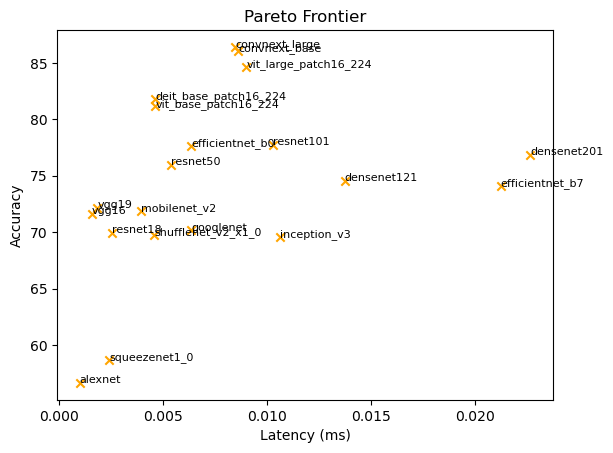

In [33]:
for model_name, metrics in results.items():
    print(f"{model_name}, acc: {metrics['accuracy']}, mean latency: {metrics['latency']:.3f} ms")
    
plt.scatter(latencies, accuracies, label="Models", color='orange', marker='x')

for model_name, metrics in results.items():
    plt.text(metrics['latency'], metrics['accuracy'], model_name, fontsize=8)

plt.title("Pareto Frontier")
plt.xlabel("Latency (ms)")
plt.ylabel("Accuracy")

current = datetime.now().strftime("%Y%m%d_%H%M%S")
plt.savefig(f"figures/Pareto_Frontier_{current}.png")

In [41]:
def get_n_params(model):
    return sum(p.numel() for p in model.parameters())

get_n_params(model_zoo['resnet18'])

11689512

In [43]:
for model_name, metrics in results.items():
    print(f"{model_name}, acc: {metrics['accuracy']}, mean latency: {metrics['latency']:.3f} ms, num_of_parameters: {get_n_params(model_zoo[model_name])}")

resnet18, acc: 69.94, mean latency: 0.003 ms, num_of_parameters: 11689512
resnet50, acc: 75.96, mean latency: 0.005 ms, num_of_parameters: 25557032
resnet101, acc: 77.74, mean latency: 0.010 ms, num_of_parameters: 44549160
vgg16, acc: 71.62, mean latency: 0.002 ms, num_of_parameters: 138357544
vgg19, acc: 72.18, mean latency: 0.002 ms, num_of_parameters: 143667240
densenet121, acc: 74.58, mean latency: 0.014 ms, num_of_parameters: 7978856
densenet201, acc: 76.82, mean latency: 0.023 ms, num_of_parameters: 20013928
mobilenet_v2, acc: 71.92, mean latency: 0.004 ms, num_of_parameters: 3504872
inception_v3, acc: 69.56, mean latency: 0.011 ms, num_of_parameters: 27161264
efficientnet_b0, acc: 77.64, mean latency: 0.006 ms, num_of_parameters: 5288548
efficientnet_b7, acc: 74.1, mean latency: 0.021 ms, num_of_parameters: 66347960
squeezenet1_0, acc: 58.64, mean latency: 0.002 ms, num_of_parameters: 1248424
alexnet, acc: 56.64, mean latency: 0.001 ms, num_of_parameters: 61100840
googlenet, acc

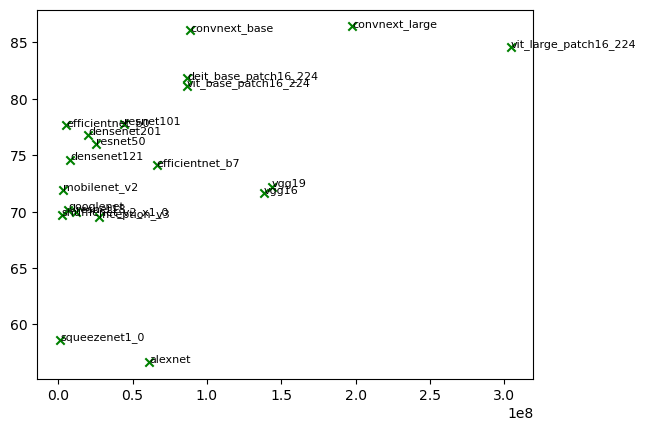

In [48]:
num_of_params = [get_n_params(model_zoo[model_name]) for model_name, metrics in results.items()]
    
plt.scatter(num_of_params, accuracies, label="Models", color='green', marker='x')

for model_name, metrics in results.items():
    plt.text(get_n_params(model_zoo[model_name]), metrics['accuracy'], model_name, fontsize=8)

# plt.title("Pareto Frontier")
# plt.xlabel("Latency (ms)")
# plt.ylabel("Num of Params")

# current = datetime.now().strftime("%Y%m%d_%H%M%S")
# plt.savefig(f"figures/Pareto_Frontier_{current}.png")
    

In [46]:
num_of_params

metrics['latency']

0.008494399738311767